In [1]:
import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd
import d3p
from twinify.napsu_mq.napsu_mq import NapsuMQModel
from twinify.napsu_mq import rubins_rules as rubin
from twinify.napsu_mq import marginal_query
from twinify.napsu_mq.markov_network import MarkovNetwork
from twinify.napsu_mq import maximum_entropy_inference as mei
from twinify.napsu_mq import privacy_accounting
from tests.napsu_mq.binary_logistic_regression_generator import BinaryLogisticRegressionDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import PerfectSeparationError
from tqdm import tqdm

In [2]:
n = 2000
n_syn_datasets = 100
n_syn_dataset = n

epsilon = 1.0
delta = n**(-2)

conf_levels = np.linspace(0.05, 0.95, 19)
true_params = jnp.array((2.0, -1.0))
d = true_params.shape[0] + 1


def gen_data(rng):
    data_gen = BinaryLogisticRegressionDataGenerator(true_params)
    data = data_gen.generate_data(n, rng)
    x_values = data_gen.x_values
    values_by_feature = data_gen.values_by_feature

    return data, x_values, values_by_feature

def get_dp_suff_stat(rng, queries, data):
    suff_stat = jnp.sum(queries.flatten()(data), axis=0)
    sensitivity = np.sqrt(suff_stat.shape[0])
    sigma_DP = privacy_accounting.sigma(epsilon, delta, sensitivity)
    dp_suff_stat = suff_stat + sigma_DP * jax.random.normal(key=rng, shape=suff_stat.shape)
    return dp_suff_stat, sigma_DP

def record(ci, conf_level, dim, repeat_ind):
    return {
        "has_coverage": int(ci[0] <= true_params[dim].item() <= ci[1]),
        "conf_level": conf_level,
        "dim": dim,
        "repeat_ind": repeat_ind
    }


def logistic_regression(datasets, col_to_predict=None, add_constant=True):
    m, n, d = datasets.shape
    if col_to_predict is None: col_to_predict = d - 1
    feature_cols = set(range(d))
    feature_cols.remove(col_to_predict)
    feature_cols = list(feature_cols)

    num_coefs = d if add_constant else d - 1
    q = np.zeros((m, num_coefs))
    u = np.zeros((m, num_coefs))
    for i in range(m):
        dataset = datasets[i,:,:]
        feature_array = sm.add_constant(dataset[:, feature_cols], has_constant="add") if add_constant else dataset[:, feature_cols]
        y_array = dataset[:, col_to_predict]

        try:
            syn_model = sm.GLM(y_array, feature_array, family=sm.families.Binomial())
            syn_result = syn_model.fit()

            q[i, :] = syn_result.params
            u[i, :] = syn_result.bse**2
        except PerfectSeparationError:
            q[i, :] = np.full(num_coefs, np.nan)
            u[i, :] = np.full(num_coefs, np.nan)

    return q, u

In [3]:
n_repeats = 50
records = []
rng = d3p.random.PRNGKey(74249069)
rngs = d3p.random.split(rng, n_repeats)

for i in tqdm(range(n_repeats)):
    data_rng, inference_rng, sampling_rng = d3p.random.split(rngs[i], 3)
    data_rng = d3p.random.convert_to_jax_rng_key(data_rng)
    
    data, x_values, values_by_feature = gen_data(data_rng)
    data = pd.DataFrame(data, dtype="category")

    model = NapsuMQModel(queries=[tuple(range(d))])
    result = model.fit(
        data=data,
        rng=inference_rng,
        epsilon=epsilon,
        delta=delta,
        show_progress=False
    )

    synthetic_dfs = result.generate(
        rng=sampling_rng, 
        num_data_per_parameter_sample=n_syn_dataset, 
        num_parameter_samples=n_syn_datasets,
        single_dataframe=False
    )

    syn_datasets = np.stack(synthetic_dfs, axis=0).astype(int)

    q, u = logistic_regression(syn_datasets, add_constant=False)
    for j in range(d - 1):
        for conf_level in conf_levels:
            qi = q[:,j]
            ui = u[:,j]
            inds = (np.isfinite(qi) & np.isfinite(ui))
            qi = qi[inds]
            ui = ui[inds]
            ci = rubin.conf_int(qi, ui, conf_level)
            records.append(record(ci, conf_level, j, i))


df = pd.DataFrame.from_records(records)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [06:01<00:00,  7.24s/it]


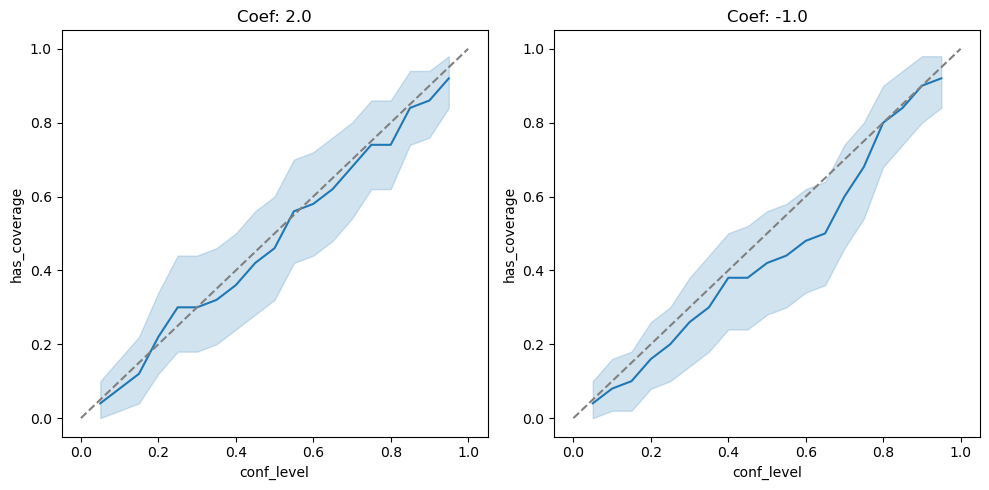

In [4]:
fig, axes = plt.subplots(1, d - 1, figsize=(5 * (d - 1), 5))
for i in range(d - 1):
    cdf = df[df.dim == i]
    ax = axes[i]
    sns.lineplot(data=cdf, x="conf_level", y="has_coverage", ax=ax)
    ax.plot((0, 1), (0, 1), linestyle="dashed", color="grey")
    ax.set_title("Coef: {}".format(true_params[i].item()))

plt.tight_layout()
plt.show()